# Milestone Project : Skimlit

## Confirm access of GPU

In [1]:
! nvidia-smi -L


GPU 0: Tesla T4 (UUID: GPU-c7ff5bf4-0b9b-40ee-9cc9-d2e344bbf84d)


## Getting Data
Since we'll be replicating the paper above (PubMed 200k RCT),
We can do so from the authors GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct

In [2]:
! git clone https://github.com/Franck-Dernoncourt/pubmed-rct
! ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 14.40 MiB/s, done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
# check what files are in the Pubmed 20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [4]:
# experiments using the 20k dataset with numbers replace by "@" sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
# checking all the files in target directory 
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## preprocess data

In [6]:
# function to read in all the lines of target text file
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
  filename: a string containing the target filepath.

  Returns:
  A list of strings with one string per line from the target filename.
  """
  with open(filename,"r") as f:
    return f.readlines()


In [7]:
# reading train data
train_lines = get_lines(data_dir+"train.txt")
train_lines[:10]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
len(train_lines)

210040

How I think our data would be best represented...
```
[{'line_number': 0,
'target': "BACKGROUND"
'text': "Emotional eating is associated with overeating and the development of esity .\n"
'total_lines: 11}]
```

In [9]:
# function that convert the text into dictionaries

def preprocess_text_with_lines_nos(filename):
  """

  Returns a list of dictionaries of abstract line data.
  Takes in filename, reads it contents and sorts through each line,
  extracting things like the target label, the text of the sentnece,
  how many sentences are in the current abstract and what sentence
  number the target line is.

  """
  input_lines = get_lines(filename) # get all the lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = []  # create an empty list of abstracts

  # loop through each line in the target file
  for line in input_lines:

      if line.startswith("###"):# check to see if its an ID
        abstract_id = line
        abstract_lines = "" # reset the abstract string if line is an ID
      elif line.isspace(): # check to see if line is a new line
        abstract_line_split = abstract_lines.splitlines()
        
        # iterate theough each line in a single abstract and count them at same time
        for abstract_line_number,abstract_lines in enumerate(abstract_line_split):
          line_data = {} # empty dict for each line
          target_text_split = abstract_lines.split("\t") #split target label from text
          line_data["line_number"] = abstract_line_number # what is the line number in abstract
          line_data["target"] = target_text_split[0] # get target label
          line_data["text"] = target_text_split[1].lower() # get target text and lower 
          line_data["total_lines"] = len(abstract_line_split) - 1   
          abstract_samples.append(line_data)
      else:
        abstract_lines += line # if above conditions arent atisfies , the line containes labelled sentence
    
  return abstract_samples
    

       




In [10]:
# get data from file and preprocess it
%%time
train_samples = preprocess_text_with_lines_nos(data_dir + "train.txt")
val_samples =  preprocess_text_with_lines_nos(data_dir + "dev.txt") # dev is another name for validation dataset
test_samples = preprocess_text_with_lines_nos(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 489 ms, sys: 99.1 ms, total: 588 ms
Wall time: 610 ms


In [11]:
# check the first abstract of our training model
train_samples[:10]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

In [12]:
# visualizing it in pandas
import pandas as pd
train_df  = pd.DataFrame (train_samples)
val_df  = pd.DataFrame (val_samples)
test_df = pd.DataFrame (test_samples)
train_df.head(14)

,line_number,target,text,total_lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,a total of @ patients with primary knee oa wer...,11
2,2,METHODS,outcome measures included pain reduction and i...,11
3,3,METHODS,pain was assessed using the visual analog pain...,11
4,4,METHODS,secondary outcome measures included the wester...,11
5,5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",11
6,6,RESULTS,there was a clinically relevant reduction in t...,11
7,7,RESULTS,the mean difference between treatment arms ( @...,11
8,8,RESULTS,"further , there was a clinically relevant redu...",11
9,9,RESULTS,these differences remained significant at @ we...,11


In [13]:
# distribution of labels in traning data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

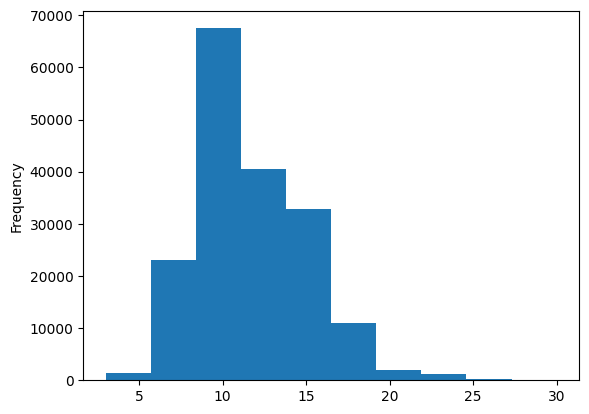

In [14]:
# checking length of different line
train_df.total_lines.plot.hist();

### Get list of sentences

In [15]:
# convert abstract text_lines into list
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

In [16]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels 

In [17]:
### one hot encoding labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))

## check what ourlabels
train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [18]:
import tensorflow as tf
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

## Label encode labels

In [19]:
# extract labels ('target' columns) and encode them into integrers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_label_encoder = label_encoder.transform(test_df["target"].to_numpy())

# chech encoded labels
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [20]:
# get classes into words vwrsion
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes , class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Series of Modeling experiments

Model0: Baseline model

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# create a Pipeline
model_0 = Pipeline([
    ("tf-idf",TfidfVectorizer()),
    ("clf",MultinomialNB())
])

# fit the pipeline to traiing data
model_0.fit(train_sentences,train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [22]:
# evaluating baseline model
model_0.score(val_sentences,val_labels_encoded)

0.7218323844829869

In [23]:
# Make preds using our baseline Model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

Getting the helper functions for comparing predictions

In [24]:
! wget https://raw.githubusercontent.com/Ronit-Wanare/SkimLit/main/helper_functions.py

--2023-05-20 12:05:45--  https://raw.githubusercontent.com/Ronit-Wanare/SkimLit/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-05-20 12:05:45 (116 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [25]:
from helper_functions import calculate_results

In [26]:
# calculate baseline results
baseline_results = calculate_results(val_labels_encoded,
                                    baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Perparing our data for deep sequence models
* Vectorization
* Embedding Layer

In [27]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [28]:
# how long is each sentence on average?
sent_len = [len(sentence.split())for sentence in train_sentences]
avg_sent_len = np.mean(sent_len)
avg_sent_len

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <BarContainer object of 20 artists>)

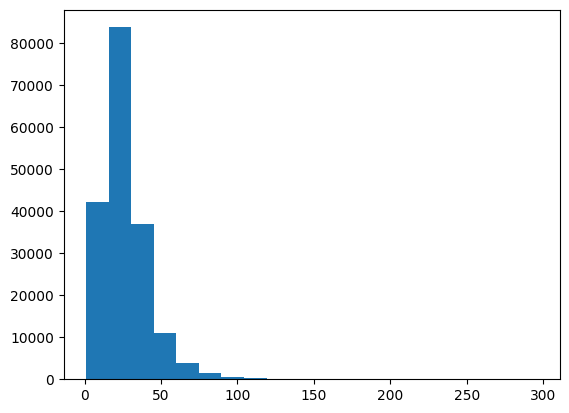

In [29]:
# whats the distribution look like
import matplotlib.pyplot as plt
plt.hist(sent_len,bins=20)

In [30]:
#how long of sentence length covers 95% of data
output_seq_len = int(np.percentile(sent_len,95))
output_seq_len

55

In [31]:
# maximum seq length in traiing set
max(sent_len)

296

### Text vectorization layer

In [32]:
# how many vocal in our dataset (taken from table 2 in: https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000

In [33]:
# create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens,
                                    output_sequence_length= output_seq_len)

In [34]:
# adapt text_vectorizer to traiing sentence
text_vectorizer.adapt(train_sentences)

In [35]:
# test out text_vecotrizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print (f"Text: \n{target_sentence}")
print (f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer( [target_sentence])}")

Text: 
regarding reproductive outcome , the differences between the two groups were also not significant .

Length of text: 15

Vectorized text: [[ 539 3869   86    2  102   30    2   51   24    9  138   31   37    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [36]:
# how many wrods in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print (f"Number of words in vocab: {len (rct_20k_text_vocab)}")
print (f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print (f"Least common words ir the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words ir the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [37]:
# get the cofig of text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Embedding layer to create custom text_embeddings


In [38]:
token_embed = layers.Embedding(input_dim = len(rct_20k_text_vocab), # length of vocab
                               output_dim=128, # note: different embedding sizes result in drastically different number of parameters
                               mask_zero=True, # use masking to handle variable sequence length
                              name="token_embedding")

In [39]:
# show an example embedding
print (f"Sentence before vectorization: \n {target_sentence} \n")
vectorized_sentence =  text_vectorizer ([target_sentence])
print (f"Sentence after vectorization (before embedding): \n {vectorized_sentence} \n")
embedded_sentence = token_embed (vectorized_sentence)
print (f"Sentence after embedding: \n {embedded_sentence} \n")
print (f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization: 
 regarding reproductive outcome , the differences between the two groups were also not significant . 

Sentence after vectorization (before embedding): 
 [[ 539 3869   86    2  102   30    2   51   24    9  138   31   37    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]] 

Sentence after embedding: 
 [[[ 0.03963784  0.02266199 -0.00567278 ... -0.0195504   0.03007865
   -0.04527707]
  [-0.03173481 -0.04726914  0.01275365 ... -0.04191316  0.03698089
   -0.04381121]
  [ 0.02510902  0.03196367 -0.009021   ... -0.00848749 -0.00199187
   -0.01377745]
  ...
  [ 0.03429182  0.0218212   0.01315879 ...  0.03962858 -0.04875926
    0.0331427 ]
  [ 0.03429182  0.0218212   0.01315879 ...  0.03962858 -0.04875926
    0.0331427 ]
  [ 0.03429182  0.0218212   0.01315879 ...  0.03962858 -0.04875926
    0.03314

## Creating Datasets to load them and run fast

In [40]:
# turn our data into tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [41]:
# take the tesorflow data sets and turn them in to prefetced datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1 : Conv1D with tocken embedddings

In [42]:
# Creating Conv1D model to process sequence
inputs = layers.Input(shape=(1,),dtype=tf.string)
text_vectors = text_vectorizer(inputs)#vectorizer text input
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64,kernel_size=5,padding="same",activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector from conv layer
outputs = layers.Dense(num_classes,"softmax")(x)
model_1 = tf.keras.Model(inputs,outputs)

# compiling the model
model_1.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [43]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [44]:
# fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=0.1*len(train_dataset),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 54s 71ms/step - loss: 0.9444 - accuracy: 0.6192 - val_loss: 0.7047 - val_accuracy: 0.7319
Epoch 2/3
562/562 [==============================] - 13s 23ms/step - loss: 0.6607 - accuracy: 0.7563 - val_loss: 0.6370 - val_accuracy: 0.7671
Epoch 3/3
562/562 [==============================] - 6s 11ms/step - loss: 0.6172 - accuracy: 0.7762 - val_loss: 0.5940 - val_accuracy: 0.7872


In [45]:
# evaluate on whole model
model_1.evaluate(valid_dataset)

945/945 [==============================] - 7s 7ms/step - loss: 0.5939 - accuracy: 0.7885


[0.5938853621482849, 0.7884946465492249]

In [46]:
# model predictions (our model predict prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs,model_1_pred_probs.shape

945/945 [==============================] - 4s 4ms/step


(array([[4.69942540e-01, 1.49137065e-01, 7.62564093e-02, 2.79049605e-01,
         2.56143678e-02],
        [4.06512082e-01, 3.00511509e-01, 1.35386297e-02, 2.70908654e-01,
         8.52909405e-03],
        [1.19680665e-01, 8.10488127e-03, 1.28770503e-03, 8.70881617e-01,
         4.50689804e-05],
        ...,
        [3.79007110e-06, 5.66200120e-04, 4.76732617e-04, 1.79611231e-06,
         9.98951435e-01],
        [6.21987246e-02, 4.60498333e-01, 1.11970007e-01, 7.75460005e-02,
         2.87786961e-01],
        [2.16094360e-01, 5.92652559e-01, 4.25664112e-02, 7.08264932e-02,
         7.78601170e-02]], dtype=float32),
 (30212, 5))

In [47]:
# convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs,axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [48]:
model_1_results = calculate_results(val_labels_encoded,
                                    model_1_preds)
model_1_results

{'accuracy': 78.84946378922282,
 'precision': 0.7852964600619384,
 'recall': 0.7884946378922283,
 'f1': 0.7860997556682535}

In [49]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## MOdel 2: Feature extaction with pretrained token embeddings with USE(universal sentence encoder)

In [50]:
# DOwmload pretrained Tensorflow Hub USE
import tensorflow_hub as hub
tf_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                     trainable=False,
                                     name="USE")

In [51]:
# Test out the pretrained embedding on a random sentence
import random
random_train_sentence = random.choice (train_sentences)
print (f"Random sentence: \n {random_train_sentence}")
use_embedded_sentence = tf_embedding_layer ([random_train_sentence])
print (f"Setence after embedding: \n{use_embedded_sentence} \n")
print (f"Length of sentence embedding: {len (use_embedded_sentence)}")

Random sentence: 
 naltrexone , an antagonist at the mu-opioid receptor , improves drinking behavior in some but not all patients probably by blocking the positive reinforcement of alcohol .
Setence after embedding: 
[[ 0.02494229  0.03628096 -0.05815976 -0.06682689  0.00295024  0.07404762
  -0.01540851 -0.0256483  -0.02956447  0.07393125  0.06069548 -0.02984718
   0.02968649  0.05457928 -0.08191984 -0.08018951 -0.08252624 -0.04895527
  -0.05514803  0.058752   -0.01870528  0.03305596  0.05807574  0.00752135
   0.04904261  0.0148112  -0.02919322 -0.01434911  0.02413335  0.00340948
  -0.0609446   0.08341159  0.01856763 -0.05033221 -0.06652253  0.05442017
   0.06334404  0.00449377 -0.05233721 -0.05953987 -0.05436257  0.05794043
  -0.02906313 -0.02024007  0.03310013  0.04960083  0.07541779 -0.05394452
   0.01877164 -0.00164115  0.00702088 -0.0707679   0.02760462 -0.03071936
  -0.08257274 -0.03081533 -0.03980095 -0.04606857  0.00124286 -0.04897083
  -0.01774385  0.06827803  0.01641553  0.05

In [52]:
# Model2 :using USE layer
inputs = layers.Input(shape=[],dtype=tf.string)
pretrained_embeddings = tf_embedding_layer(inputs)
x = layers.Dense(128,activation="relu")(pretrained_embeddings)
x = layers.Dense(64,activation="relu")(x)
output= layers.Dense(num_classes,activation="softmax")(x)
model_2 = tf.keras.Model(inputs,output)

# compile the model
model_2.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [53]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 5)                 325       
                                                                 
Total params: 256,872,069
Trainable params: 74,245
Non-trainable params: 256,797,824
_________________________________________________________________


In [54]:
# Fit model 2 to the data
history_model_2 = model_2.fit(train_dataset,
                             epochs=3,
                            steps_per_epoch=int(0.1*len(train_dataset)),
                            validation_data=valid_dataset,
                            validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 13s 18ms/step - loss: 0.8908 - accuracy: 0.6526 - val_loss: 0.7906 - val_accuracy: 0.6925
Epoch 2/3
562/562 [==============================] - 8s 15ms/step - loss: 0.7449 - accuracy: 0.7092 - val_loss: 0.7233 - val_accuracy: 0.7214
Epoch 3/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7132 - accuracy: 0.7259 - val_loss: 0.6878 - val_accuracy: 0.7394


In [55]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 16s 17ms/step - loss: 0.6966 - accuracy: 0.7328


[0.6965988874435425, 0.7328214049339294]

In [56]:
model_2_preds_probs = model_2.predict(valid_dataset)
model_2_preds_probs

945/945 [==============================] - 13s 13ms/step


array([[4.9088368e-01, 2.6297203e-01, 1.6115275e-03, 2.3924471e-01,
        5.2880314e-03],
       [3.8038307e-01, 4.7529554e-01, 3.3278849e-03, 1.3781801e-01,
        3.1754915e-03],
       [2.5093541e-01, 4.4374503e-02, 1.9896280e-02, 6.6977847e-01,
        1.5015368e-02],
       ...,
       [1.1288258e-03, 3.8595221e-03, 4.8394531e-02, 3.8133186e-04,
        9.4623578e-01],
       [4.6905060e-03, 5.8184620e-02, 2.4430051e-01, 2.3374113e-03,
        6.9048697e-01],
       [3.5697892e-01, 5.2115345e-01, 1.0403816e-01, 6.2764133e-03,
        1.1553162e-02]], dtype=float32)

In [57]:
model_2_preds = tf.argmax(model_2_preds_probs,axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [58]:
model_2_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_2_preds)
model_2_results

{'accuracy': 73.28213954719979,
 'precision': 0.733999212801829,
 'recall': 0.7328213954719979,
 'f1': 0.7319275392067788}

In [59]:
baseline_results


{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

MOdel3: conv1D with character embeddinggs
The paper which we're replicating states they used a combination of token and character-level embeddings.
Previously we've token-level embeddings but we'll need to do similar steps for characters if we want to use char-level embeddings.

## Creating character level tockenizer

In [60]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [61]:
# make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

In [62]:
split_chars(random_train_sentence)

'n a l t r e x o n e   ,   a n   a n t a g o n i s t   a t   t h e   m u - o p i o i d   r e c e p t o r   ,   i m p r o v e s   d r i n k i n g   b e h a v i o r   i n   s o m e   b u t   n o t   a l l   p a t i e n t s   p r o b a b l y   b y   b l o c k i n g   t h e   p o s i t i v e   r e i n f o r c e m e n t   o f   a l c o h o l   .'

In [63]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentences) for sentences in val_sentences]
test_chars = [split_chars(sentences) for sentences in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [64]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

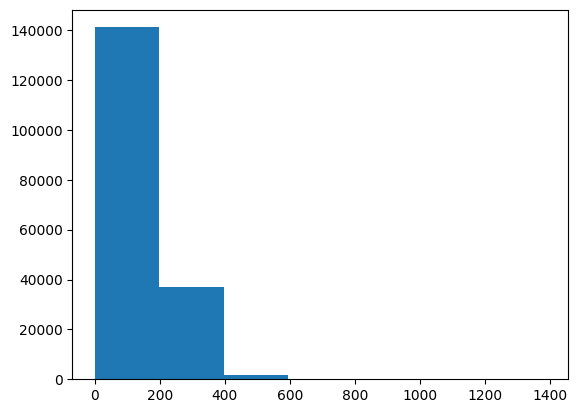

In [65]:
# check the distribution of sentences
import matplotlib.pyplot as plt
plt.hist(char_lens,bins=7);

In [66]:
# find what charecter length covers 95% of the data
output_seq_char_len = int(np.percentile(char_lens,95))
output_seq_char_len

290

In [67]:
# get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [68]:
from keras.layers.serialization import text_vectorization
NUM_CHAR_TOKEN = len(alphabet) + 2 # +2 for space and [UNK]
char_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKEN,
                                    output_sequence_length = output_seq_char_len,
                                    standardize ="lower_and_strip_punctuation",
                                    name = "char_vectorizer")

In [69]:
# Adapt character vectorizer to train data
char_vectorizer.adapt(train_chars)

In [70]:
# check vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different charecter in character vocab:{len(char_vocab)}")
print(f"5 most common chars:{char_vocab[:5]}")
print(f"5 most common chars:{char_vocab[-5:]}")


Number of different charecter in character vocab:28
5 most common chars:['', '[UNK]', 'e', 't', 'i']
5 most common chars:['k', 'x', 'z', 'q', 'j']


In [71]:
random_train_chars = random.choice(train_chars)
print(f"chrified text :\n{random_train_chars}")
print(f"length of random train chars:{len(random_train_chars.split())}")
vectorized_chars = char_vectorizer(random_train_chars)
print(f" vectorized random train_chars :\n{vectorized_chars}")


chrified text :
k g - @   g r o u p   .
length of random train chars:10
 vectorized random train_chars :
[23 18 18  8  7 16 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0]


In [72]:
# create char ebedding layer
char_embed = layers.Embedding(input_dim = len(char_vocab),
                              output_dim=25,
                              mask_zero=True,
                              name="char_embed")

In [73]:
# Test our char emded layer
print(f"charified text:\n {random_train_chars}")
char_eembed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embed chars :\n {char_eembed_example}")
char_eembed_example.shape

charified text:
 k g - @   g r o u p   .
Embed chars :
 [[[-0.01683191  0.02078375 -0.04527704 ...  0.02821586  0.03568948
   -0.01810968]
  [-0.02070918  0.00936579  0.04551132 ...  0.00614562  0.02488308
    0.04791831]
  [-0.02070918  0.00936579  0.04551132 ...  0.00614562  0.02488308
    0.04791831]
  ...
  [ 0.02290055 -0.04638926  0.04054992 ...  0.03011033 -0.00012524
    0.00695535]
  [ 0.02290055 -0.04638926  0.04054992 ...  0.03011033 -0.00012524
    0.00695535]
  [ 0.02290055 -0.04638926  0.04054992 ...  0.03011033 -0.00012524
    0.00695535]]]


TensorShape([1, 290, 25])

## Building a Conv1D model to fit on character embeddinggs

In [74]:
inputs = layers.Input(shape=(1,),dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64,kernel_size=5,padding="same",activation="relu")(char_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes,activation="softmax")(x)
model_3 = tf.keras.Model(inputs,outputs)

# compile the model
model_3.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [75]:
model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_4 (Dense)             (None, 5)                 325 

In [76]:
# create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars,train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars,val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars,test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [77]:
# fit the model
model_3.fit(train_char_dataset,
            epochs=3,
            steps_per_epoch = 0.1*len(train_char_dataset),
            validation_data = val_char_dataset,
            validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 10s 14ms/step - loss: 1.4610 - accuracy: 0.3463 - val_loss: 1.4095 - val_accuracy: 0.4023
Epoch 2/3
562/562 [==============================] - 6s 11ms/step - loss: 1.3771 - accuracy: 0.4142 - val_loss: 1.3454 - val_accuracy: 0.4375
Epoch 3/3
562/562 [==============================] - 5s 9ms/step - loss: 1.3362 - accuracy: 0.4469 - val_loss: 1.3218 - val_accuracy: 0.4508


In [78]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 3s 3ms/step


array([[0.16365723, 0.2577226 , 0.24368155, 0.20073453, 0.13420413],
       [0.11676446, 0.1729121 , 0.14605038, 0.07428826, 0.4899849 ],
       [0.1069329 , 0.17944969, 0.38743436, 0.12599744, 0.20018561],
       ...,
       [0.08237667, 0.12976195, 0.26009035, 0.05711801, 0.47065303],
       [0.06093403, 0.1112695 , 0.23954318, 0.05077195, 0.53748137],
       [0.14534166, 0.18474096, 0.21367447, 0.08159563, 0.37464723]],
      dtype=float32)

In [79]:
model_3_preds = tf.argmax(model_3_pred_probs,axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 4, 2, ..., 4, 4, 4])>

In [80]:
model_3_results = calculate_results(val_labels_encoded,
                                    model_3_preds)
model_3_results

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 44.922547332185886,
 'precision': 0.3776921236963299,
 'recall': 0.44922547332185886,
 'f1': 0.4000593112659646}

## Model 4 : Combining pretrained token embeddings + character embeddings

In [81]:
# 1 . steup token input/model
token_inputs = layers.Input(shape=[],dtype=tf.string,name="token_input")
token_embeddings = tf_embedding_layer(token_inputs)
token_output = layers.Dense(128,"relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs,token_output)

# 2. steup char input models
char_inputs = layers.Input(shape=(1,),dtype = tf.string,name = "char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings)
char_model = tf.keras.Model(char_inputs,char_bi_lstm)

# 3. Concatenate token and char inputs
token_char_concat = layers.Concatenate(name = "token_char_hybrid")([token_model.output,
                                                                    char_model.output])

# 4. Create outputs layers
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128,"relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes,"softmax")(final_dropout)

# construct model with char n token inputs
model_4 = tf.keras.Model(inputs=[token_model.input,char_model.input],
                         outputs = output_layer,
                         name="token_and_char_embeddings")


In [82]:
model_4.summary()

Model: "token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 USE (KerasLayer)               (None, 512)          256797824   ['token_i

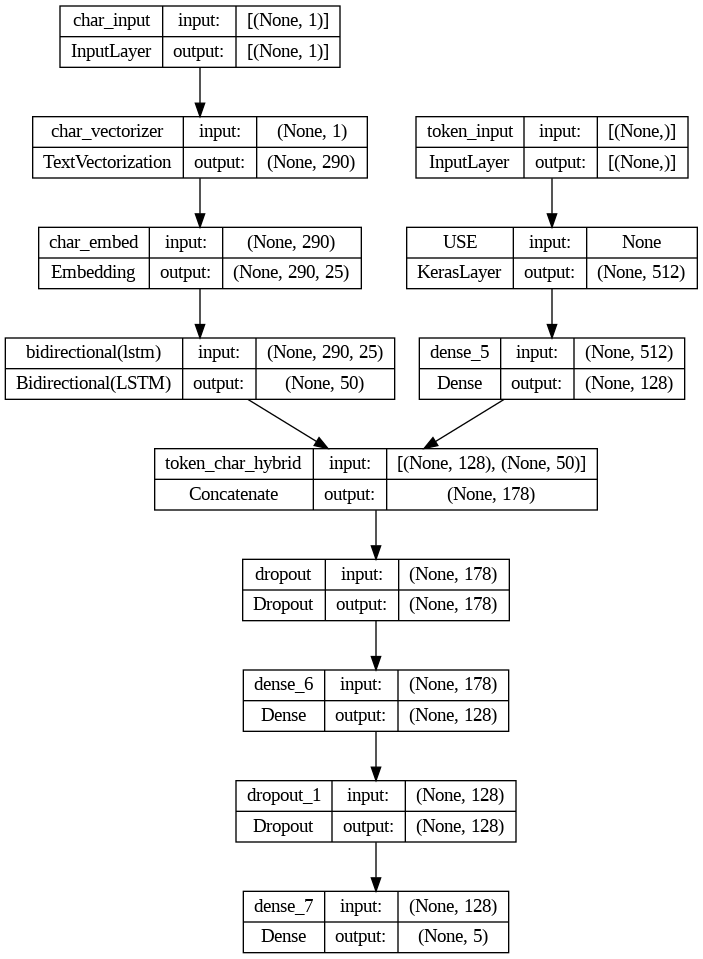

In [83]:
# plot hybrid token and character model
from keras.utils import plot_model
plot_model(model_4,show_shapes=True)

In [84]:
# compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [85]:
# combining token and char data into tf.datasets
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences,train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data,train_char_token_labels))

## prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [86]:
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences,val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data,val_char_token_labels))

val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [87]:
# check out put datasets
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [88]:
# fitting the model
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch = (0.1 * len(train_char_token_dataset) ),
                              epochs = 3,
                              validation_data=val_char_token_dataset,
                              validation_steps = (0.1*len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 55s 77ms/step - loss: 0.9891 - accuracy: 0.6073 - val_loss: 0.7998 - val_accuracy: 0.6931
Epoch 2/3
562/562 [==============================] - 38s 68ms/step - loss: 0.8050 - accuracy: 0.6897 - val_loss: 0.7226 - val_accuracy: 0.7211
Epoch 3/3
562/562 [==============================] - 45s 79ms/step - loss: 0.7796 - accuracy: 0.6993 - val_loss: 0.7024 - val_accuracy: 0.7303


In [89]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 35s 37ms/step - loss: 0.7025 - accuracy: 0.7332


[0.7024706602096558, 0.7332186102867126]

In [90]:
# make preds using model_4
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 25s 21ms/step


array([[4.4682959e-01, 3.6040056e-01, 4.5011039e-03, 1.8284109e-01,
        5.4277475e-03],
       [3.3789352e-01, 5.2285999e-01, 3.1945622e-03, 1.3274871e-01,
        3.3031541e-03],
       [2.7581850e-01, 1.0352926e-01, 3.8458265e-02, 5.5977046e-01,
        2.2423523e-02],
       ...,
       [9.7067241e-04, 7.5457431e-03, 1.0725197e-01, 4.0190204e-04,
        8.8382971e-01],
       [1.1044715e-02, 6.0884926e-02, 3.2179344e-01, 4.9927421e-03,
        6.0128415e-01],
       [2.1354952e-01, 3.7192312e-01, 3.1156373e-01, 3.0522656e-02,
        7.2440915e-02]], dtype=float32)

In [91]:
# formar preds into classes
model_4_preds = tf.argmax(model_4_pred_probs,axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [92]:
model_4_results = calculate_results(val_labels_encoded,
                            model_4_preds)
model_4_results

{'accuracy': 73.32185886402753,
 'precision': 0.7336543967600689,
 'recall': 0.7332185886402753,
 'f1': 0.7297689867728826}

## Model_5 : Transfer learning with pretrained embedding + char embeddings + positional embeddings


In [93]:
train_df.head()

,line_number,target,text,total_lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,a total of @ patients with primary knee oa wer...,11
2,2,METHODS,outcome measures included pain reduction and i...,11
3,3,METHODS,pain was assessed using the visual analog pain...,11
4,4,METHODS,secondary outcome measures included the wester...,11


# Create positional embeddings

In [96]:
# hoe many different line numbers are there
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<ipython-input-97-5c930ce7952a>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df["line_number"]);


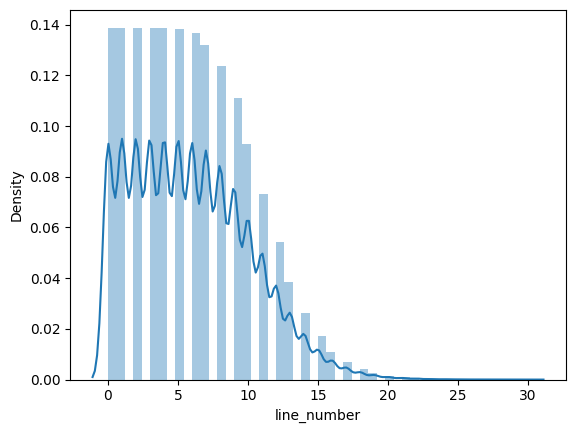

In [97]:
# checking distribution of line numbers
import seaborn as sns
sns.distplot(train_df["line_number"]);

In [140]:
# use tensorflow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(),depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(),depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(),depth=15)
train_line_numbers_one_hot[:10] , val_line_numbers_one_hot[0].shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([15]))

In [141]:
# how many different total_lines are there
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

<ipython-input-142-243bbb139fd8>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df["total_lines"]);


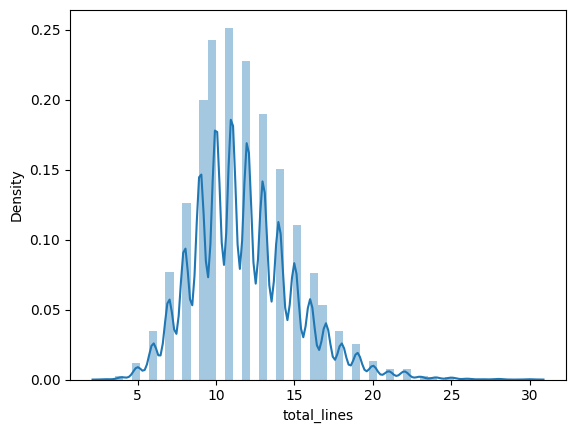

In [142]:
# checking distribuiton
sns.distplot(train_df["total_lines"]);

In [143]:
# check the coverage of 'total_lines' values 
np.percentile(train_df.total_lines,95)

18.0

In [144]:
# use tensorflow to create one-hot-encoded tensors of our "total_lines" column
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(),depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(),depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(),depth=20)
train_total_lines_one_hot[:10] , train_total_lines_one_hot.shape

(<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

## Building a tribrid embedding model
1. create token level model
2. create a char level model
3. create model for "line_number" feature
4. create a model for "total_lines"feature
5. combine the outputs of 1n2 using tf.keras.layers.Concatenate
6. combine the outputs of 3,4,5
7. combine the output layer to accept the tribrided embeddings and ouput model probabilities.
8. combine the inputs of 1,2,3,4 and outputs

In [146]:
val_line_numbers_one_hot[0].shape

TensorShape([15])

In [147]:
train_total_lines_one_hot[0].shape

TensorShape([20])

In [148]:
# Token inputs
token_inputs = layers.Input(shape=[],dtype=tf.string,name = "token_inputs")
token_embeddings = tf_embedding_layer(token_inputs)
token_outputs = layers.Dense(28,activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs,token_outputs)

# char inputs
char_inputs = layers.Input(shape=(1,),dtype=tf.string,name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs,char_bi_lstm)

# line_number model 
line_num_inputs = layers.Input(shape=(15,),dtype=tf.float32,name="line_num_input")
x = layers.Dense(32,"relu")(line_num_inputs)
line_num_model = tf.keras.Model(line_num_inputs,x)

# total_line model
total_lines_inputs = layers.Input(shape=(20,),dtype=tf.float32,name="total_lines_input")
y = layers.Dense(32,"relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs,y)

# combine token n char embeddings into hybrid embeddings
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embeddings")([token_model.output,
                                                                               char_model.output])
z = layers.Dense(256,"relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)
# combine positional embeddings with combined token n chr embeddings
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embeddings")([line_num_model.output,
                                                                                  total_lines_model.output,
                                                                                  z])

# create output layer
output_layer = layers.Dense(5,"softmax",name="output_layer")(tribrid_embeddings)

# put together model with all kinds of embeddings
model_5 = tf.keras.Model(inputs = [line_num_model.input,
                                   total_lines_model.input,
                                   token_model.input,
                                   char_model.input],
                         outputs = output_layer,
                         name="model_5_tribrid_embedding")

In [149]:
# model_5 summary
model_5.summary()

Model: "model_5_tribrid_embedding"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 USE (KerasLayer)               (None, 512)          256797824   ['token_i

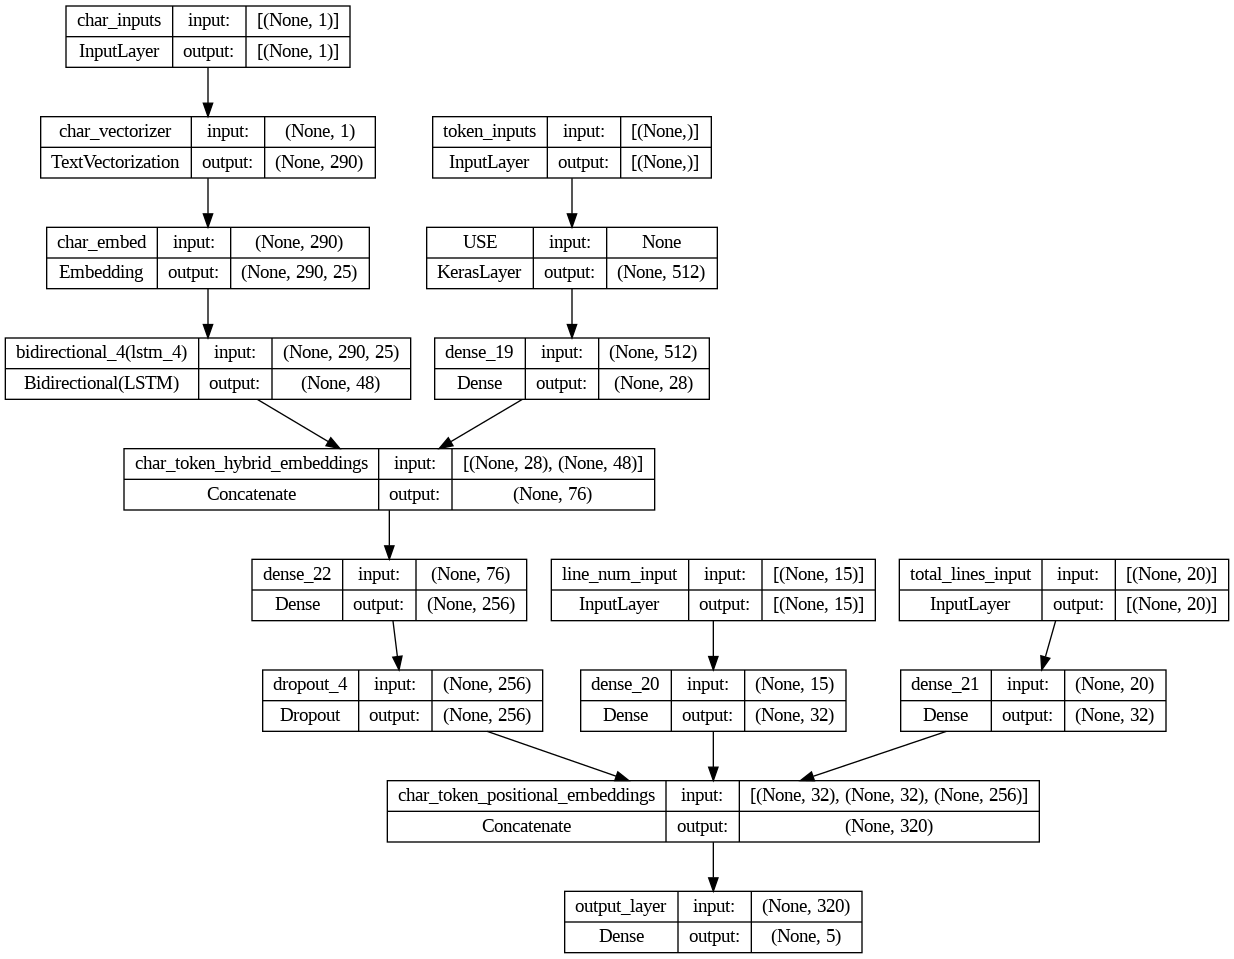

In [150]:
## PLoting the model with shapes
plot_model(model_5,show_shapes=True)

In [151]:
# model_5 compiling
model_5.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # helps to prevent overfitting
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Creating tribrid datasets

In [152]:
# create train and validation data with all four kids of input data
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data,train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# val dataset

val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                                val_total_lines_one_hot,
                                                                val_sentences,
                                                                val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data,val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [153]:
val_line_numbers_one_hot[0].shape , train_line_numbers_one_hot[0].shape

(TensorShape([15]), TensorShape([15]))

In [154]:
# check input shapes
train_char_token_pos_dataset , val_char_token_pos_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

## Fitting and evaluating model

In [162]:
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch = int(0.1*len(train_char_token_pos_dataset)),
                              epochs=5,
                              validation_data = val_char_token_pos_dataset,
                              validation_steps = int(0.1*len(val_char_token_pos_dataset)))

Epoch 1/5
562/562 [==============================] - 29s 51ms/step - loss: 0.9338 - accuracy: 0.8376 - val_loss: 0.9287 - val_accuracy: 0.8378
Epoch 2/5
562/562 [==============================] - 31s 55ms/step - loss: 0.9229 - accuracy: 0.8454 - val_loss: 0.9253 - val_accuracy: 0.8434
Epoch 3/5
562/562 [==============================] - 30s 54ms/step - loss: 0.9197 - accuracy: 0.8455 - val_loss: 0.9309 - val_accuracy: 0.8358
Epoch 4/5
562/562 [==============================] - 31s 55ms/step - loss: 0.9274 - accuracy: 0.8427 - val_loss: 0.9243 - val_accuracy: 0.8344
Epoch 5/5
562/562 [==============================] - 30s 54ms/step - loss: 0.9287 - accuracy: 0.8420 - val_loss: 0.9205 - val_accuracy: 0.8424


In [163]:
# make prediction
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset)
model_5_pred_probs

945/945 [==============================] - 19s 21ms/step


array([[0.58995134, 0.08192717, 0.02316176, 0.27231103, 0.03264874],
       [0.6177649 , 0.07436077, 0.10820498, 0.18447396, 0.01519541],
       [0.34998807, 0.10485383, 0.15542376, 0.3298743 , 0.05985994],
       ...,
       [0.02581189, 0.07312921, 0.03031754, 0.02473316, 0.84600824],
       [0.01907194, 0.34074315, 0.10181091, 0.01930211, 0.51907194],
       [0.08469576, 0.64224094, 0.12569252, 0.02936926, 0.11800157]],
      dtype=float32)

In [164]:
model_5_preds = tf.argmax(model_5_pred_probs,axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 0, ..., 4, 4, 1])>

In [165]:
model_5_results = calculate_results(val_labels_encoded,
                                    model_5_preds)
model_5_results

{'accuracy': 84.29763008076262,
 'precision': 0.8459151968561757,
 'recall': 0.8429763008076261,
 'f1': 0.8389418096184909}

In [170]:
all_model_results = pd.DataFrame({"model_0_baseline" : baseline_results,
                                 "model_1_custom_token_embedding":model_1_results,
                                 "model_2_pretrained_token_embedding":model_2_results,
                                 "model_3_custom_char_embedding":model_3_results,
                                 "model_4_hybrid_char_token_embedding":model_4_results,
                                 "model_5_pos_char_token_embedding":model_5_results})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.849464,0.785296,0.788495,0.786100
model_2_pretrained_token_embedding,73.282140,0.733999,0.732821,0.731928
model_3_custom_char_embedding,44.922547,0.377692,0.449225,0.400059
model_4_hybrid_char_token_embedding,73.321859,0.733654,0.733219,0.729769
model_5_pos_char_token_embedding,84.297630,0.845915,0.842976,0.838942


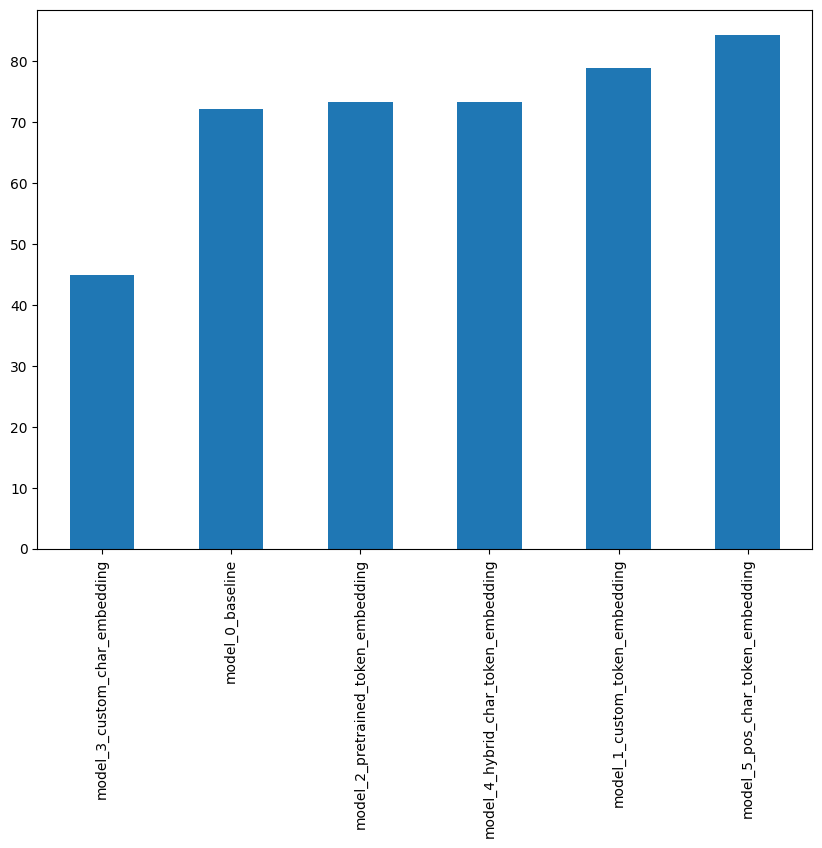

In [173]:
## sorting model by accuracy
all_model_results.sort_values("accuracy",ascending=True)["accuracy"].plot(kind="bar",figsize=(10,7));

In [174]:
## Saving the model
model_5.save("skimlit_tribrid_model")

Doing some predictons on test data with our best model

In [175]:
test_df.head()

,line_number,target,text,total_lines
0,0,BACKGROUND,this study analyzed liver function abnormaliti...,8
1,1,RESULTS,a post hoc analysis was conducted with the use...,8
2,2,RESULTS,liver function tests ( lfts ) were measured at...,8
3,3,RESULTS,survival analyses were used to assess the asso...,8
4,4,RESULTS,the percentage of patients with abnormal lfts ...,8


In [176]:
test_char_token_pos_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                                test_total_lines_one_hot,
                                                                test_sentences,
                                                                test_chars))
test_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_pos_dataset = tf.data.Dataset.zip((test_char_token_pos_data,test_char_token_pos_labels))
test_char_token_pos_dataset = test_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [177]:
test_pred_probs = model_5.predict(test_char_token_pos_dataset)
test_pred_probs

942/942 [==============================] - 27s 28ms/step


array([[0.276213  , 0.10752771, 0.08955314, 0.4394224 , 0.08728378],
       [0.26056147, 0.05251421, 0.44854793, 0.1935124 , 0.04486409],
       [0.04131296, 0.02058486, 0.87284386, 0.04818031, 0.01707797],
       ...,
       [0.05640725, 0.12584488, 0.05111641, 0.03863869, 0.7279928 ],
       [0.06544783, 0.16056319, 0.07367905, 0.03683819, 0.66347176],
       [0.0526368 , 0.55098593, 0.21902572, 0.02879188, 0.14855966]],
      dtype=float32)

In [179]:
test_preds = tf.argmax(model_5_pred_probs,axis=1)
test_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 0, ..., 4, 4, 1])>

In [189]:
classes = test_df["target"].unique()
classes

array(['BACKGROUND', 'RESULTS', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE'],
      dtype=object)

In [211]:
pred_classes = classes[test_preds]
pred_classes

array(['BACKGROUND', 'BACKGROUND', 'BACKGROUND', ..., 'OBJECTIVE',
       'OBJECTIVE', 'RESULTS'], dtype=object)